# Inverse Problem: General Workflow and Examples

In this example script, we'll reproduce many of the plots from the fitting release paper ([Conroy et al. 2020](http://phoebe-project.org/publications/2020Conroy+)).

For the few figures not included here, see the following:

* Figure 4: [Propagating Distributions through Constraints](distribution_constraints.ipynb)
* Figure 6: [Comparing PHOEBE 2, Legacy, jktebop, ellc](backends_compare_legacy_jktebop_ellc.ipynb)
* FIgure 7: [Minimal Gaussian Processes](minimal_GPs.ipynb)

# Setup


Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

First we'll import, set our plotting options, and set a fixed random seed so that our noise model is reproducible between runs.

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

In [3]:
import phoebe
import numpy as np

logger = phoebe.logger('error')

# we'll set the random seed so that the noise model is reproducible
np.random.seed(123456789)

# Create fake "observations"

Now we'll create a fake set of observations by setting some parameter values, running a forward model, and adding some simple random noise on both the fluxes and RVs.

In [4]:
b = phoebe.default_binary()
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7)
b.set_value('incl@binary', 80)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0)
b.set_value('vgamma', 80)

lctimes = phoebe.linspace(0, 10, 1005)
rvtimes = phoebe.linspace(0, 10, 105)
b.add_dataset('lc', compute_times=lctimes)
b.add_dataset('rv', compute_times=rvtimes)

b.add_compute('ellc', compute='fastcompute')
b.set_value_all('ld_mode', 'lookup')
b.run_compute(compute='fastcompute')

fluxes = b.get_value('fluxes@model') + np.random.normal(size=lctimes.shape) * 0.01
fsigmas = np.ones_like(lctimes) * 0.02

rvsA = b.get_value('rvs@primary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsB = b.get_value('rvs@secondary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsigmas = np.ones_like(rvtimes) * 20

100%|██████████| 3/3 [00:00<00:00, 50.54it/s]


# Create a new bundle/system

Now we'll start over "blind" with a fresh bundle and import our "fake" observations in datasets.

In [5]:
b = phoebe.default_binary()

b.set_value('latex_repr', component='binary', value='orb')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')

b.add_dataset('lc', 
              compute_phases=phoebe.linspace(0,1,201),
              times=lctimes, 
              fluxes=fluxes, 
              sigmas=fsigmas, 
              dataset='lc01')

b.add_dataset('rv', 
              compute_phases=phoebe.linspace(0,1,201),
              times=rvtimes, 
              rvs={'primary': rvsA, 'secondary': rvsB}, 
              sigmas=rvsigmas, 
              dataset='rv01')

b.set_value_all('ld_mode', 'lookup')

For the sake of this example, we'll assume that we know the orbital period *exactly*, and so can see that our observations phase nicely.  

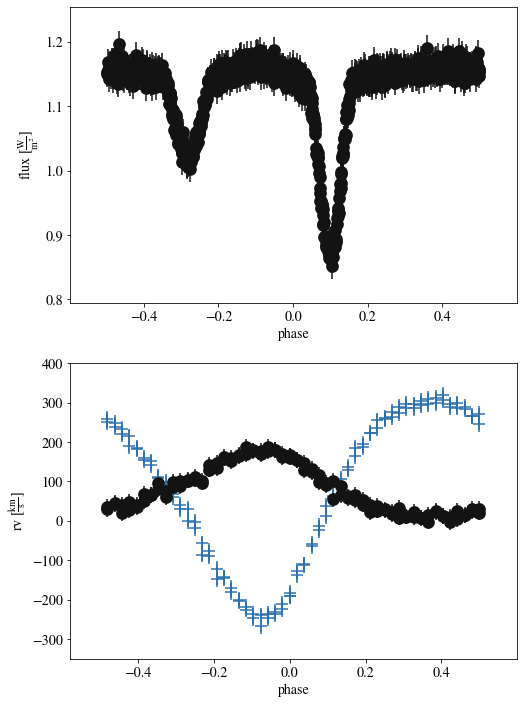

In [6]:
afig, mplfig = b.plot(x='phases', show=True)

# Run rv_geometry estimator

First we'll run the [rv_geometry estimator](../api/phoebe.parameters.solver.estimator.rv_geometry.md) via [b.add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md) and [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md).

In [7]:
b.add_solver('estimator.rv_geometry',
             rv_datasets='rv01',
             solver='rvgeom_solver')

<ParameterSet: 7 parameters | qualifiers: use_server, expose_model, comments, phase_nbins, orbit, rv_datasets, phase_bin>

In [8]:
b.run_solver(kind='rv_geometry', solution='rv_geom_sol')

<ParameterSet: 17 parameters | components: primary, secondary>

By calling [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md) with `trial_run=True`, we can see the proposed values by the estimator.

In [9]:
print(b.adopt_solution('rv_geom_sol', trial_run=True))

ParameterSet: 6 parameters
   t0_supconj@binary@orbit@com...: 0.12223876290276331 d
         q@binary@orbit@component: 0.3040356444904351
     asini@binary@orbit@component: 7.613101426349146 solRad
       ecc@binary@orbit@component: 0.14411956104422038
      per0@binary@orbit@component: 33.35345468009398 deg
                    vgamma@system: 80.12789348809366 km / s


And by plotting the solution, we can see the underlying Keplerian orbit that was fitted to the RVs to determine these values.  

This reproduces Figure 1

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig1.png" id="fig1" alt="Figure 1" width="800px"/>

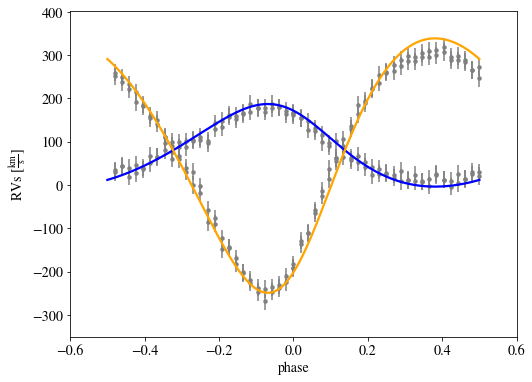

In [10]:
afig, mplfig = b.plot(solution='rv_geom_sol',
                      show=True, save='figure_rv_geometry.pdf')

# Run lc_geometry estimator

Next we'll run the [lc_geometry estimator](../api/phoebe.parameters.solver.estimator.lc_geometry.md).

In [11]:
b.add_solver('estimator.lc_geometry',
             lc_datasets='lc01',
             solver='lcgeom_solver')

<ParameterSet: 11 parameters | qualifiers: t0_near_times, orbit, use_server, expose_model, comments, lc_combine, analytical_model, interactive, phase_nbins, lc_datasets, phase_bin>

In [12]:
b.run_solver(solver='lcgeom_solver', solution='lc_geom_sol')

<ParameterSet: 21 parameters | qualifiers: fitted_twigs, fitted_values, primary_depth, fitted_units, analytic_phases, input_sigmas, comments, analytic_best_model, analytic_fluxes, secondary_depth, primary_phase, adopt_distributions, eclipse_edges, input_phases, input_fluxes, secondary_phase, adopt_values, secondary_width, primary_width, adopt_parameters, orbit>

Again, calling [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md) with `trial_run=True` shows the proposed values.

In [13]:
print(b.adopt_solution('lc_geom_sol', trial_run=True))

ParameterSet: 5 parameters
   t0_supconj@binary@orbit@com...: 0.10030408652447893 d
       ecc@binary@orbit@component: 0.19475939216406313
      per0@binary@orbit@component: 19.00172557347593 deg
   requivsumfrac@binary@orbit@...: 0.48587449389546145
   teffratio@binary@orbit@comp...: 0.8372251155019044


By plotting the solution, we get Figure 2, which shows the best two gaussian model as well as the detected positions of mid-eclipse, ingress, and egress which were used to compute the proposed values.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig2.png" id="fig2" alt="Figure 2" width="800px"/>

/home/kyle/.local/lib/python3.8/site-packages/phoebe/dependencies/autofig/call.py:1097: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([x, y])
/home/kyle/.local/lib/python3.8/site-packages/phoebe/dependencies/autofig/call.py:1098: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points = np.array([x, y]).T.reshape(-1, 1, 2)


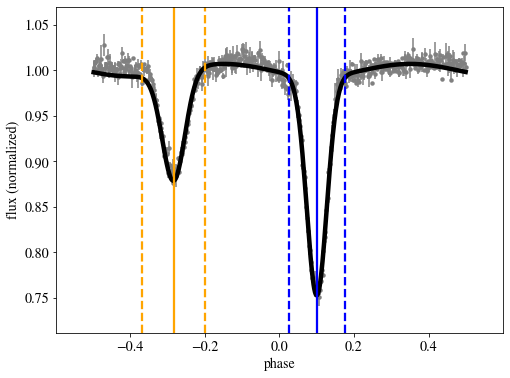

In [14]:
afig, mplfig = b.plot(solution='lc_geom_sol',
                      show=True, save='figure_lc_geometry.pdf')

Figure 5 exhibits eclipse masking by adopting `mask_phases` from the `lc_geometry` solution.  Note that by default, `mask_phases` is not included in `adopt_parameters`, which is why it was not included when calling [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md) with `trial_mode=True` (all available proposed parameters could be shown by passing `adopt_parameters='*'`.  For the sake of this figure, we'll only adopt the `mask_phases`, plot the dataset with that mask applied, but then disable the mask for the rest of this example script.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig5.png" id="fig5" alt="Figure 5" width="800px"/>

In [15]:
b.adopt_solution('lc_geom_sol', adopt_parameters='mask_phases')

<ParameterSet: 1 parameters>

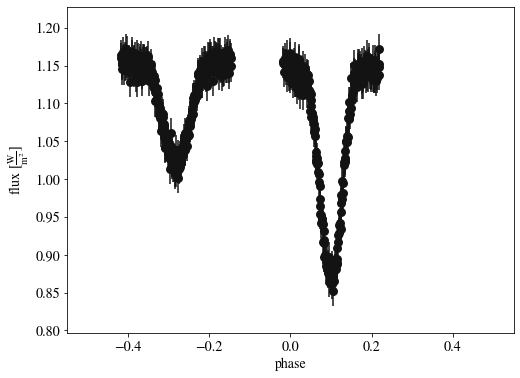

In [16]:
_ = b.plot(context='dataset', dataset='lc01', x='phases', xlim=(-0.55,0.55),
           save='figure_lc_geometry_mask.pdf', show=True)

In [17]:
b.set_value('mask_enabled@lc01', False)

# Run ebai estimator

And finally, we'll do the same for the [ebai estimator](../api/phoebe.parameters.solver.estimator.ebai.md).

In [18]:
b.add_solver('estimator.ebai',
             ebai_method='mlp',
             lc_datasets='lc01')

<ParameterSet: 8 parameters | qualifiers: orbit, use_server, comments, lc_combine, ebai_method, phase_nbins, lc_datasets, phase_bin>

In [19]:
b.run_solver(kind='ebai', solution='ebai_sol')

<ParameterSet: 13 parameters | qualifiers: input_phases, input_fluxes, fitted_twigs, fitted_values, input_sigmas, fitted_units, adopt_parameters, comments, adopt_values, orbit, ebai_fluxes, ebai_phases, adopt_distributions>

In [20]:
print(b.adopt_solution('ebai_sol', trial_run=True))

ParameterSet: 6 parameters
   t0_supconj@binary@orbit@com...: 0.10578685258964121 d
   teffratio@binary@orbit@comp...: 0.7197102455220084
   requivsumfrac@binary@orbit@...: 0.4250752826550513
     esinw@binary@orbit@component: 0.0652928238984476
     ecosw@binary@orbit@component: 0.19443023668404313
      incl@binary@orbit@component: 75.06525186745232 deg


By plotting the `ebai` solution, we reproduce Figure 3, which shows the normalized light curve observations and the resulting sample two gaussian model that is sent to the neural network.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig3.png" id="fig3" alt="Figure 3" width="800px"/>

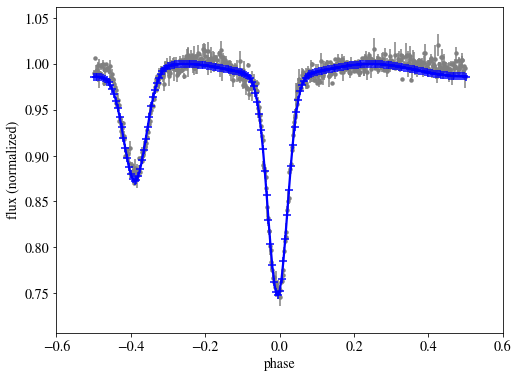

In [21]:
afig, mplfig = b.plot(solution='ebai_sol',
                      show=True, save='figure_ebai.pdf')

# Adopt from estimators

Now we'll adopt the proposed values from the two geometry estimators.

In [22]:
b.flip_constraint('asini@binary', solve_for='sma@binary')
b.adopt_solution('rv_geom_sol')

<ParameterSet: 26 parameters | contexts: component, dataset, system>

In [23]:
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('teffratio', solve_for='teff@primary')
b.adopt_solution('lc_geom_sol')

<ParameterSet: 18 parameters | contexts: component, dataset>

We'll keep the eccentricity and per0 estimates from the lc geometry, but use the ebai results to adopt the values for the temperature ratio, sum of fractional radii, and inclination.  Note that since we flipped the asini constraint earlier, that value from the rv geometry will remain fixed and the semi-major axis will be adjusted based on asini from rv geometry and incl from ebai.

In [24]:
b.adopt_solution('ebai_sol', adopt_parameters=['teffratio', 'requivsumfrac', 'incl'])

<ParameterSet: 19 parameters | kinds: star, orbit>

In [25]:
print(b.filter(qualifier=['ecc', 'per0', 'teff', 'sma', 'incl', 'q', 'requiv'], context='component'))

ParameterSet: 13 parameters
C        requiv@primary@component: 2.3492800602471537 solRad
C          teff@primary@component: 8336.688323296245 K
C          incl@primary@component: 75.06525186745232 deg
       requiv@secondary@component: 1.0 solRad
         teff@secondary@component: 6000.0 K
C        incl@secondary@component: 75.06525186745232 deg
            per0@binary@component: 19.00172557347593 deg
             ecc@binary@component: 0.19475939216406313
            incl@binary@component: 75.06525186745232 deg
               q@binary@component: 0.3040356444904351
C            sma@binary@component: 7.879263266796662 solRad
C           sma@primary@component: 1.837048623288537 solRad
C         sma@secondary@component: 6.0422146435081245 solRad


Now we can run a forward model with these adopted parameters to see how well the results from the estimators agree with the observations.  We'll also set the synthetic light curve to automatically scale to the flux-levels of the observations.

In [26]:
b.set_value_all('pblum_mode', 'dataset-scaled')

In [27]:
b.run_compute(irrad_method='none', model='after_estimators', overwrite=True)

100%|██████████| 201/201 [00:21<00:00,  9.39it/s]


<ParameterSet: 8 parameters | kinds: lc, rv>

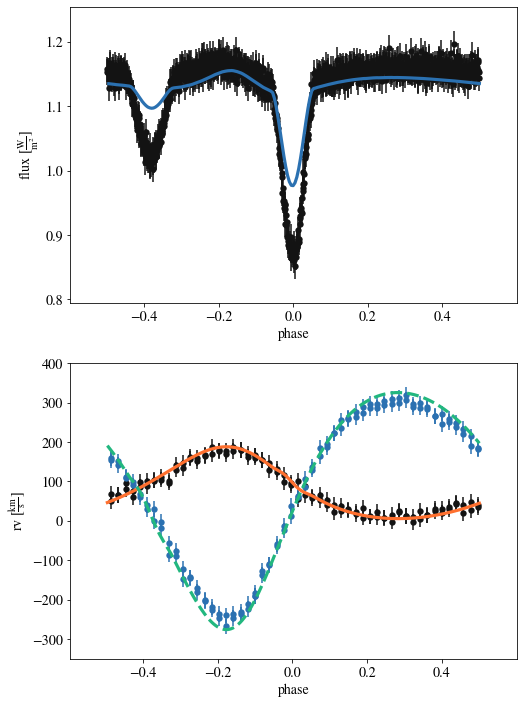

In [28]:
_ = b.plot(x='phases', m='.', show=True)

# Optimize with nelder_mead using ellc

To avoid a long burnin during sampling, we'll use the [nelder_mead optimizer](../api/phoebe.parameters.solver.optimizer.nelder_mead.md) to try to achieve better agreement with the observations.

We'll use [ellc](../api/phoebe.parameters.compute.ellc.md) as our forward-model just for the sake of computational efficiency.  

In [29]:
b.add_compute('ellc', compute='fastcompute')

<ParameterSet: 34 parameters | datasets: _default, lc01, rv01>

For the sake of optimizing, we'll keep `pblum_mode='dataset-scaled'` which will automatically re-scale the light curve to the observations at each iteration - we'll disable this later for sampling to make sure we account for any degeneracies between the luminosity and other parameters.

In [30]:
b.add_solver('optimizer.nelder_mead',
             fit_parameters=['teffratio', 'requivsumfrac', 'incl@binary', 'q', 'ecc', 'per0'],
             compute='fastcompute')

<ParameterSet: 14 parameters | qualifiers: use_server, adaptive, expose_lnprobabilities, initial_values, comments, compute, priors_combine, fit_parameters, xatol, continue_from, progress_every_niters, priors, fatol, maxiter>

In [31]:
print(b.get_solver(kind='nelder_mead'))

ParameterSet: 13 parameters
    comments@nelder_mead01@solver: 
   use_server@nelder_mead01@so...: compute
     compute@nelder_mead01@solver: fastcompute
   expose_lnprobabilities@neld...: False
   continue_from@nelder_mead01...: None
   fit_parameters@nelder_mead0...: ['teffratio', 'requivsumfrac', 'incl@binary', 'q', 'ecc', 'per0']
   initial_values@nelder_mead0...: {}
      priors@nelder_mead01@solver: []
     maxiter@nelder_mead01@solver: 1000000
    adaptive@nelder_mead01@solver: False
       xatol@nelder_mead01@solver: 0.0001
       fatol@nelder_mead01@solver: 0.0001
   progress_every_niters@nelde...: 0


In [32]:
b.run_solver(kind='nelder_mead', maxiter=10000, solution='nm_sol')

  3%|▎         | 328/10000 [09:21<4:35:56,  1.71s/it] 


<ParameterSet: 11 parameters | qualifiers: fitted_twigs, niter, fitted_values, success, initial_values, adopt_parameters, fitted_units, comments, adopt_values, message, adopt_distributions>

In [33]:
print(b.get_solution('nm_sol').filter(qualifier=['message', 'nfev', 'niter', 'success']))

ParameterSet: 3 parameters
R         message@nm_sol@solution: Optimization terminated successfully.
R           niter@nm_sol@solution: 327
R         success@nm_sol@solution: True


In [34]:
print(b.adopt_solution('nm_sol', trial_run=True))

ParameterSet: 6 parameters
   teffratio@binary@orbit@comp...: 0.8492094702313697
   requivsumfrac@binary@orbit@...: 0.40693156983529055
      incl@binary@orbit@component: 82.11213668880934 deg
         q@binary@orbit@component: 0.34949703777114627
       ecc@binary@orbit@component: 0.20067674664588728
      per0@binary@orbit@component: 24.99328826478101 deg


We'll adopt all the proposed values, and run the forward model with a new `model` tag so that we can overplot the "before" and "after".  

In [35]:
b.adopt_solution('nm_sol')

<ParameterSet: 29 parameters | contexts: component, dataset>

In [36]:
b.run_compute(compute='fastcompute', model='after_nm')

100%|██████████| 3/3 [00:00<00:00, 107.33it/s]


<ParameterSet: 8 parameters | kinds: lc, rv>

Figure 8 shows the forward-models from the parameters we adopted after estimators to those after optimization.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig8.png" id="fig8" alt="Figure 8" width="800px"/>

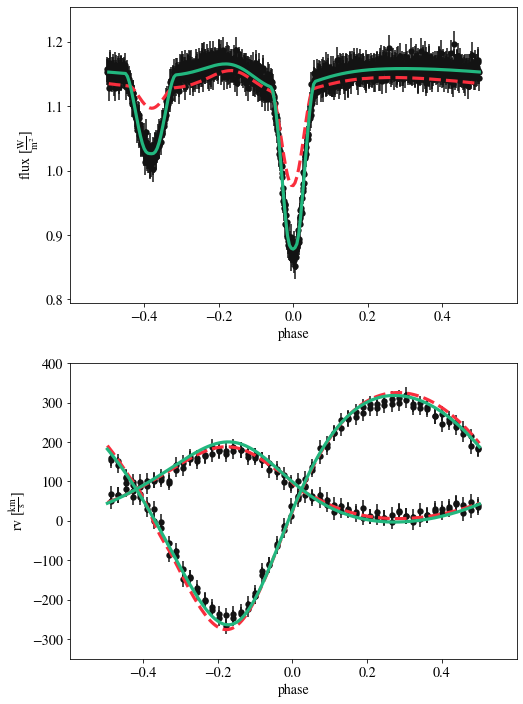

In [37]:
_ = b.plot(x='phases', 
           c={'after_estimators': 'red', 'after_nm': 'green', 'dataset': 'black'}, 
           linestyle={'after_estimators': 'dashed', 'after_nm': 'solid'},
           marker={'dataset': '.'},
           save='figure_optimizer_nm.pdf', show=True)

It's also always a good idea to check to see if our model agrees between different backends and approximations.  So we'll compute the same forward-model using PHOEBE and overplot ellc and PHOEBE (note there are some minor differences... if this were a real system that we were publishing we may want to switch to using PHOEBE for determining the final uncertainties)

In [38]:
b.run_compute(compute='phoebe01', model='after_nm_phoebe')

100%|██████████| 201/201 [00:24<00:00,  8.37it/s]


<ParameterSet: 8 parameters | kinds: lc, rv>

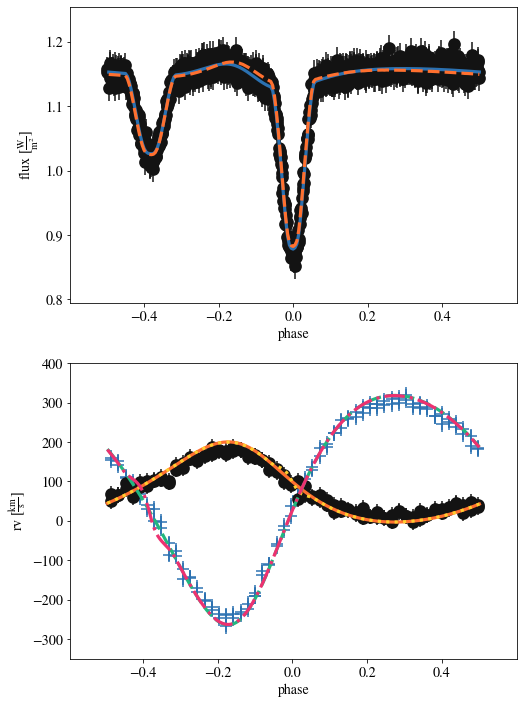

In [39]:
_ = b.plot(x='phases', model='after_nm*', show=True)

# Determine uncertainties with emcee

So that we don't ignore any degeneracies between parameters and the luminosities, we'll turn off the dataset-scaling we used for optimizing and make sure we have a reasonable value of `pblum@primary` set to roughly obtain the out-of-eclipse flux levels of the observations.  To get a good rough guess for `pblum@primary`, we'll use the flux-scaling from `pblum_mode='dataset-scaled'` (see [compute_pblums API docs](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md) for details).

In [40]:
pblums_scaled = b.compute_pblums(compute='fastcompute', model='after_nm')

In [41]:
print(pblums_scaled)

{'pblum@primary@lc01': <Quantity 12.77016971 W>, 'pblum@secondary@lc01': <Quantity 1.40181504 W>, 'pblum@primary@rv01': <Quantity 1.59515845e+26 W>, 'pblum@secondary@rv01': <Quantity 1.75104729e+25 W>}


In [42]:
b.set_value_all('pblum_mode', 'component-coupled')

**IMPORTANT NOTE**: it is important that you only apply this automatically scaled pblum value with the same `pblum_method` as was originally used.  See [pblum method comparison](pblum_method_compare.ipynb).  Also note that if we marginalize over `pblum` using `pblum_method = 'stefan-boltzmann'` that the luminosities themselves should not be trusted - here we're just marginalizing as a nuisance parameter to account for any degeneracies but will not report the actual values themselves, so we can use the cheaper method.  If we wanted to switch to `pblum_method='phoebe'` at this point (or to use the phoebe backend), we could re-run a single forward model with `pblum_method='phoebe'` and `pblum_mode='dataset-scaled'` first, and then make the call to `b.compute_pblums` using the resulting model.

In [43]:
b.set_value('pblum', dataset='lc01', component='primary', value=pblums_scaled['pblum@primary@lc01'])

In [44]:
print(b.compute_pblums(compute='fastcompute', dataset='lc01', pbflux=True))

{'pblum@primary@lc01': <Quantity 12.77016971 W>, 'pblum@secondary@lc01': <Quantity 1.40181504 W>, 'pbflux@lc01': <Quantity 1.12777071 W / m2>}


And although it doesn't really matter, let's marginalize over 'sma' and 'incl' instead of 'asini' and 'incl'.

In [45]:
b.flip_constraint('sma@binary', solve_for='asini')

<ConstraintParameter: {asini@binary@component} = {sma@binary@component} * (sin({incl@binary@component})) (solar units) => 7.613101426349146 solRad>

We'll now create our initializing distribution, including gaussian "balls" around all of the optimized values and a uniform boxcar on `pblum@primary`.

In [46]:
b.add_distribution({'teffratio': phoebe.gaussian_around(0.1),
                    'requivsumfrac': phoebe.gaussian_around(0.1),
                    'incl@binary': phoebe.gaussian_around(3),
                    'sma@binary': phoebe.gaussian_around(2),
                    'q': phoebe.gaussian_around(0.1),
                    'ecc': phoebe.gaussian_around(0.05),
                    'per0': phoebe.gaussian_around(5),
                    'pblum': phoebe.uniform_around(0.5)},
                    distribution='ball_around_optimized_solution')

<ParameterSet: 8 parameters | components: primary, binary>

We can look at this combined set of distributions, which will be used to sample the initial values of our walkers in [emcee](../api/phoebe.parameters.solver.sampler.emcee.md).

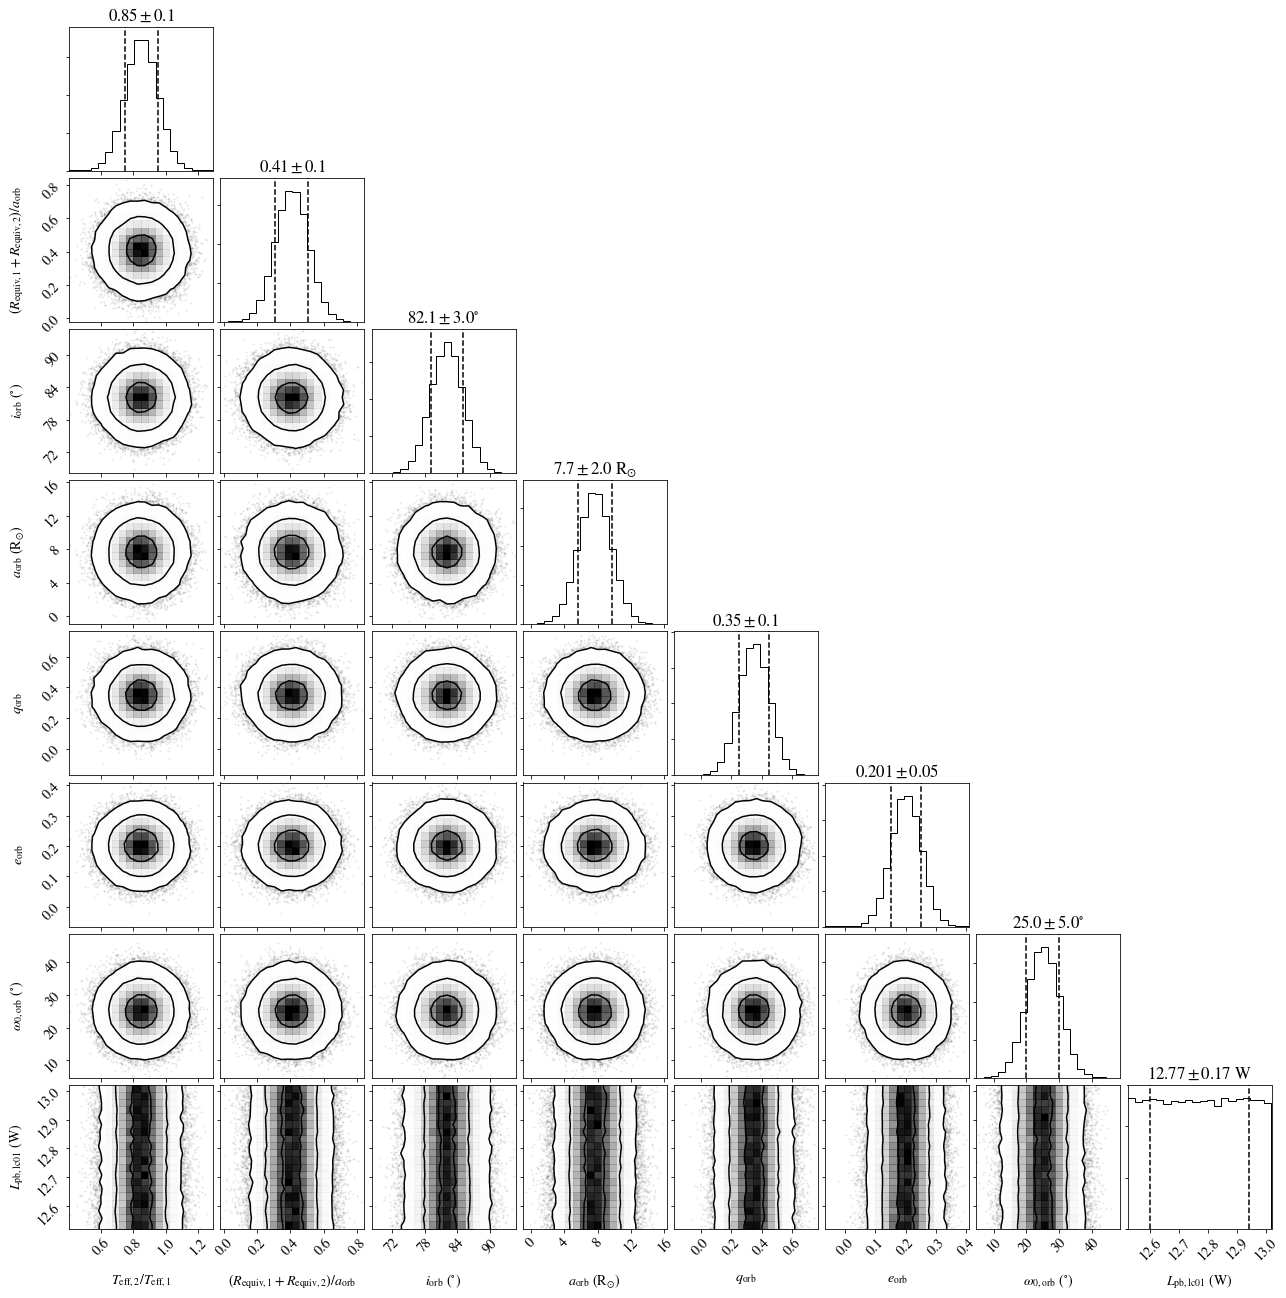

In [47]:
_ = b.plot_distribution_collection('ball_around_optimized_solution', show=True)

In [48]:
b.add_solver('sampler.emcee',
             init_from='ball_around_optimized_solution',
             compute='fastcompute',
             solver='emcee_solver')

<ParameterSet: 17 parameters | qualifiers: use_server, init_from_requires, expose_failed, burnin_factor, init_from_combine, continue_from_iter, comments, compute, niters, priors_combine, init_from, progress_every_niters, continue_from, nlags_factor, priors, nwalkers, thin_factor>

Since we'll need a lot of iterations, we'll export the solver to an HPC cluster (with [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md)) and import the solution (with [b.import_solution](../api/phoebe.frontend.bundle.Bundle.import_solution.md)).  We'll [save](../api/phoebe.parameters.ParameterSet.save.md) the bundle first so that we can interrupt the notebook and return to the following line, if needed.

For 2000 iteration on 72 processors, this should take about 2 hours.

In [49]:
b.save('inverse_paper_examples_before_emcee.bundle')
b.export_solver('inverse_paper_examples_run_emcee.py', 
                solver='emcee_solver',
                niters=2000, progress_every_niters=100, 
                nwalkers=16,
                solution='emcee_sol',
                log_level='warning',
                pause=True)

* optional:  call b.save(...) to save the bundle to disk, you can then safely close the active python session and recover the bundle with phoebe.load(...)
* run inverse_paper_examples_run_emcee.py (within mpirun or on an external machine, if desired)
* once completed, copy inverse_paper_examples_run_emcee.py.out to this directory, if necessary
* press enter to exit this pause
* call b.import_solution('inverse_paper_examples_run_emcee.py.out')

(press enter to continue)


('inverse_paper_examples_run_emcee.py',
 'inverse_paper_examples_run_emcee.py.out')

In [1]:
# only needed if starting script from here
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

import phoebe
import numpy as np

logger = phoebe.logger('error')

b = phoebe.load('inverse_paper_examples_before_emcee.bundle')

In [2]:
# NOTE: append .progress to view any of the following plots before the run has completed
b.import_solution('inverse_paper_examples_run_emcee.py.out', solution='emcee_sol')

<ParameterSet: 19 parameters | qualifiers: lnprob_cutoff, distributions_convert, failed_samples, lnprobabilities, adopt_values, progress, wrap_central_values, comments, adopt_parameters, fitted_uniqueids, fitted_units, autocorr_times, imported_job, adopt_distributions, acceptance_fractions, fitted_twigs, thin, burnin, samples>

To get as "clean" of posterior distributions as possible, we'll override the proposed thinning value and set it to 1 (effectively disabling thinning).

In [3]:
print(b.get_value('thin', solution='emcee_sol'))

27


In [4]:
b.set_value('thin', solution='emcee_sol', value=1)

Alternatively, we could run the solver locally as we've seen before, but probably would want to run less iterations:

```
b.run_solver('emcee_solver', niters=300, nwalkers=16, solution='emcee_sol')
```

in which case calling `b.import_solution` is not necessary.

Figure 9 shows the relation of any failed or rejected samples with respect to the final posteriors.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig9.png" id="fig9" alt="Figure 9" width="800px"/>

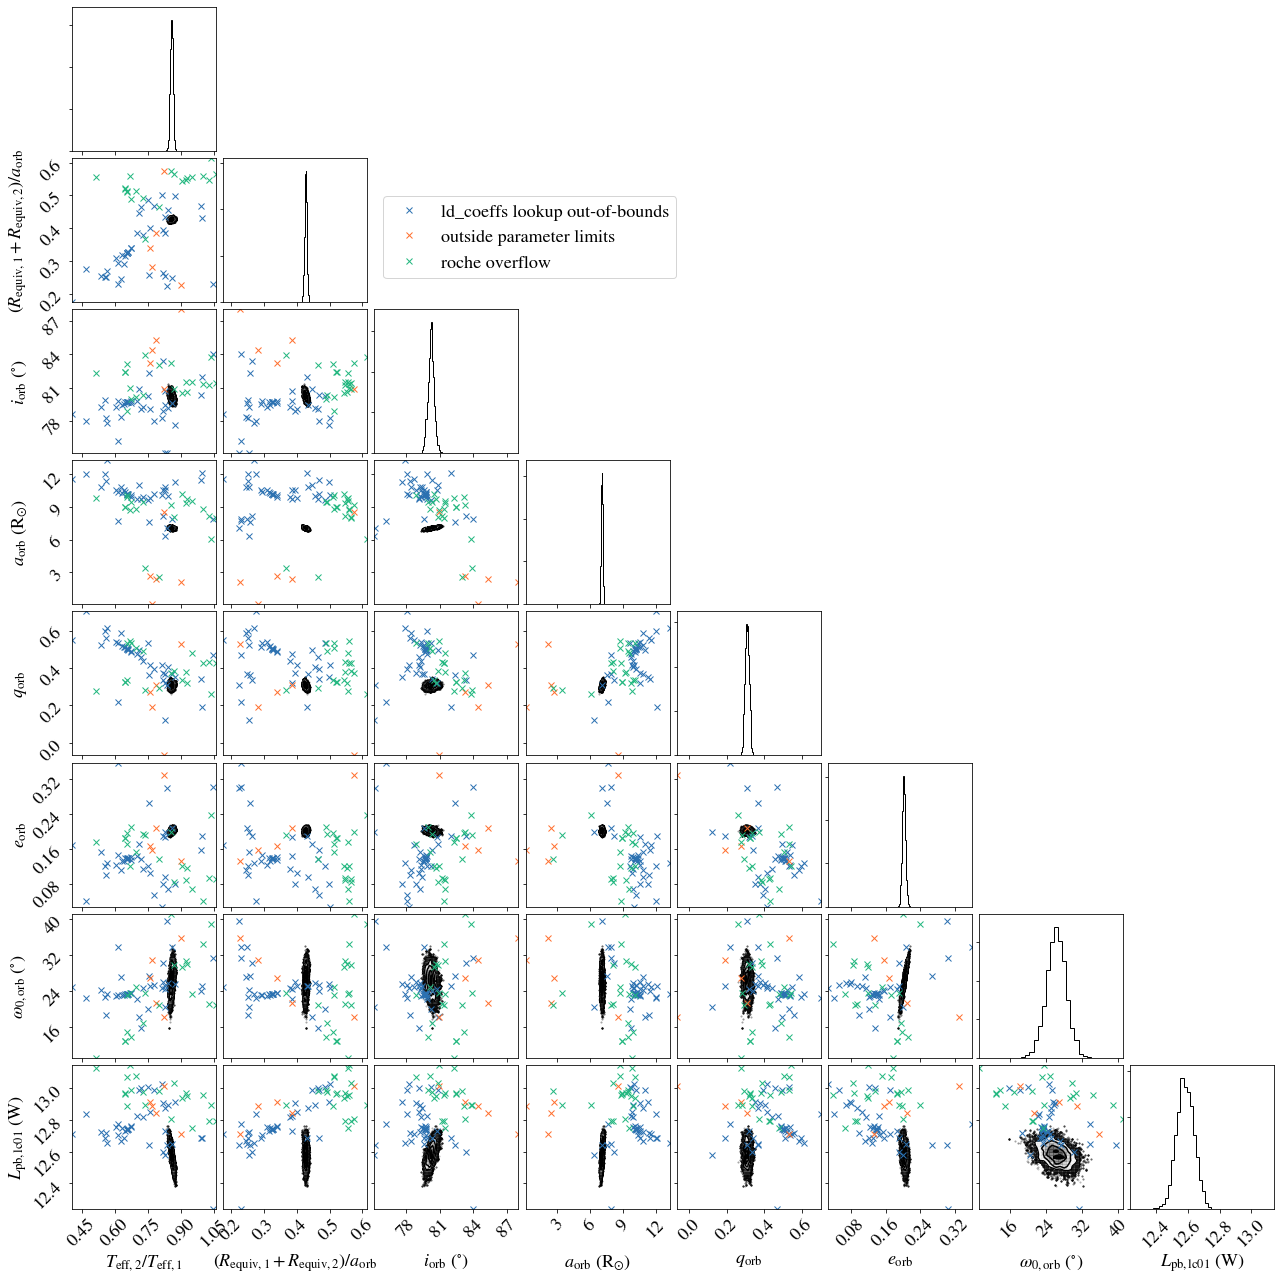

In [5]:
plt.rc('font', size=18)
_ = b.plot('emcee_sol', style='failed', 
           save='figure_emcee_failed_samples.pdf', show=True)
plt.rc('font', size=14)

# Accessing posteriors from emcee run

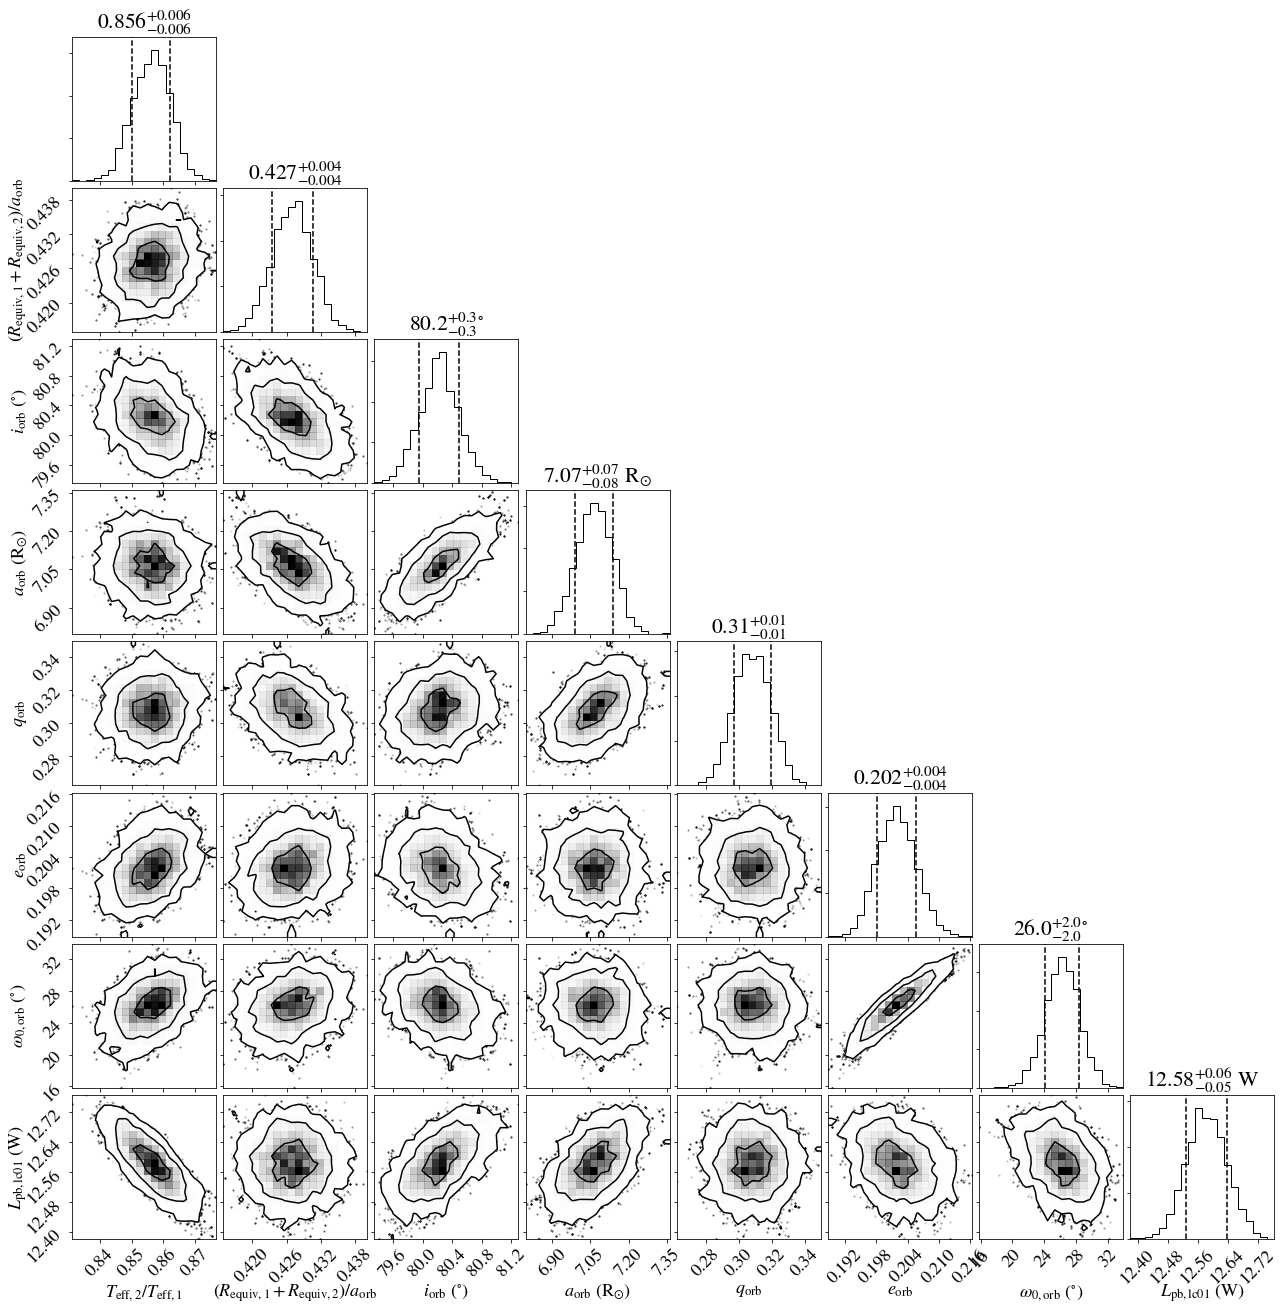

In [6]:
plt.rc('font', size=18)
_ = b.plot('emcee_sol', style='corner', show=True)
plt.rc('font', size=14)

Figure 10 compares posteriors directly from the samples to those converted to a multivariate gaussian.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig10.png" id="fig10" alt="Figure 10" width="800px"/>

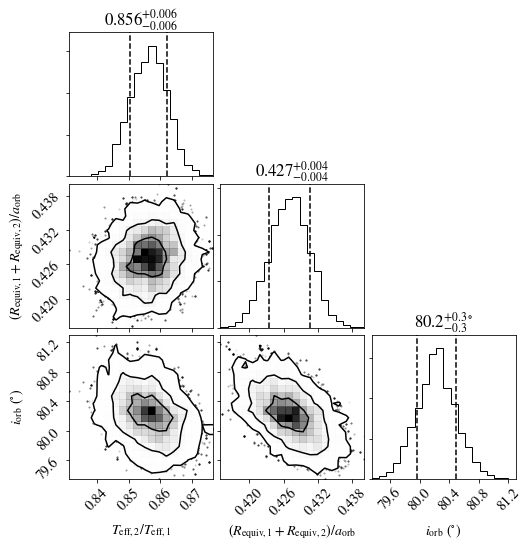

In [7]:
_ = b.plot('emcee_sol', style='corner', parameters=['teffratio', 'requivsumfrac', 'incl@binary'], 
           save='figure_posteriors_mvsamples.pdf', show=True)

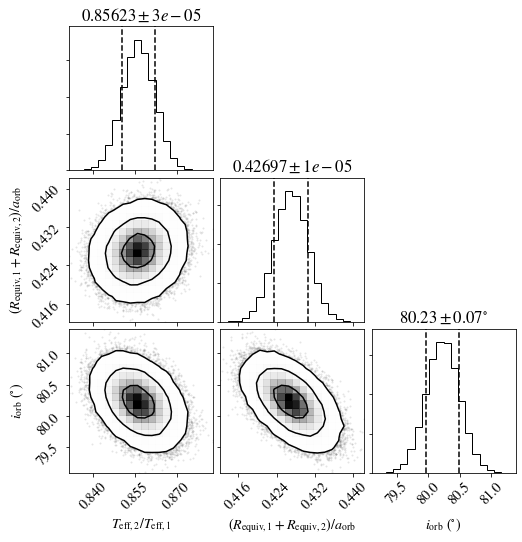

In [8]:
_ = b.plot('emcee_sol', style='corner', parameters=['teffratio', 'requivsumfrac', 'incl@binary'], 
           distributions_convert='mvgaussian',
           save='figure_posteriors_mvgaussian.pdf', show=True)

Figure 11 demonstrates how posteriors can be propagated through constraints.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig11.png" id="fig11" alt="Figure 11" width="800px"/>

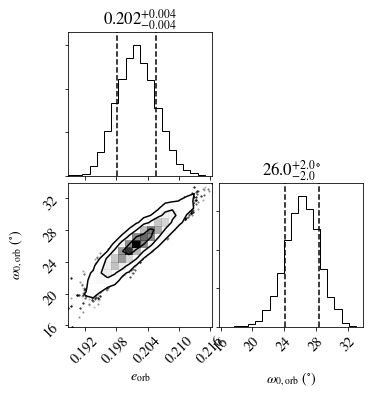

In [9]:
_ = b.plot('emcee_sol', style='corner', parameters=['ecc', 'per0'], 
           save='figure_posteriors_ew.pdf', show=True)

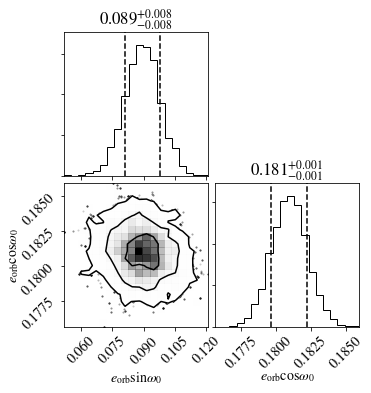

In [10]:
_ = b.plot('emcee_sol', style='corner', parameters=['esinw', 'ecosw'], 
           save='figure_posteriors_ecs.pdf', show=True)

## Accessing Uncertainty Estimates from Posteriors

A nice latex representation of the asymmetric uncertainties can be exposed via [b.uncertainties_from_distribution_collection](../api/phoebe.frontend.bundle.Bundle.uncertainties_from_distribution_collection.md) for any distribution collection - but this is particularly useful for acting on posterior distributions.

In [11]:
b.uncertainties_from_distribution_collection(solution='emcee_sol', tex=True)

teffratio@binary = 0.856 +0.006 -0.006  
requivsumfrac@binary = 0.427 +0.004 -0.004  
incl@binary = 80.2 +0.3 -0.3  deg
sma@binary = 7.07 +0.07 -0.08  solRad
q@binary = 0.31 +0.01 -0.01  
ecc@binary = 0.202 +0.004 -0.004  
per0@binary = 26.0 +2.0 -2.0  deg
pblum@lc01 = 12.58 +0.06 -0.05  W

As with the corner plots, these can also be accessed with distributions propagated through constraints into any parameterization.

In [12]:
b.uncertainties_from_distribution_collection(solution='emcee_sol', parameters=['esinw', 'ecosw'], tex=True)

esinw@binary = 0.089 +0.008 -0.008  
 ecosw@binary = 0.181 +0.001 -0.001  

## Propagating Posteriors through Forward-Model

In [13]:
b.run_compute(compute='fastcompute', 
              sample_from='emcee_sol', sample_num=500, sample_mode='3-sigma',
              model='emcee_posts', progressbar=False)

<ParameterSet: 12 parameters | kinds: rv, lc>

In [14]:
b.save('inverse_paper_examples_after_sample_from.bundle')

'inverse_paper_examples_after_sample_from.bundle'

In [15]:
# only needed if starting script from here
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

import phoebe
import numpy as np

logger = phoebe.logger('error')

b = phoebe.load('inverse_paper_examples_after_sample_from.bundle')

And lastly, Figure 12 demonstrates posteriors propagated through the forward model.

<img src="http://phoebe-project.org/images/figures/2020Conroy+_fig12.png" id="fig12" alt="Figure 12" width="800px"/>

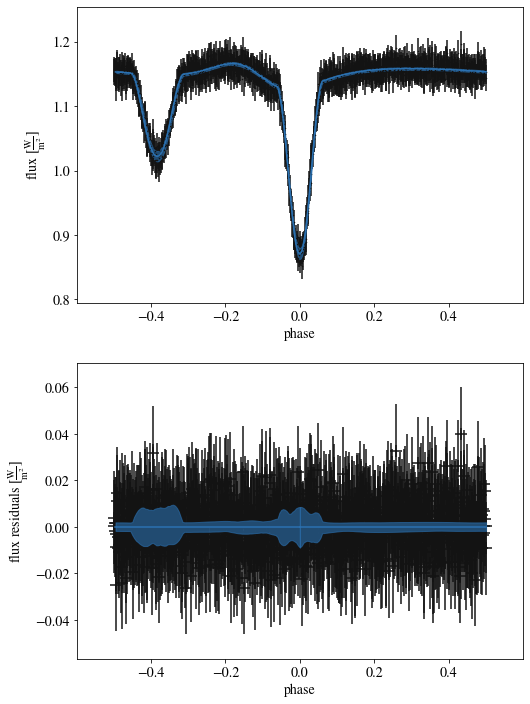

In [16]:
_ = b.plot(kind='lc', model='emcee_posts', x='phases', y='fluxes', 
           s={'dataset': 0.005},
           marker={'dataset': '.'})
_ = b.plot(kind='lc', model='emcee_posts', x='phases', y='residuals', 
           z={'dataset': 0, 'model': 1},
           save='figure_posteriors_sample_from_lc.pdf', show=True)

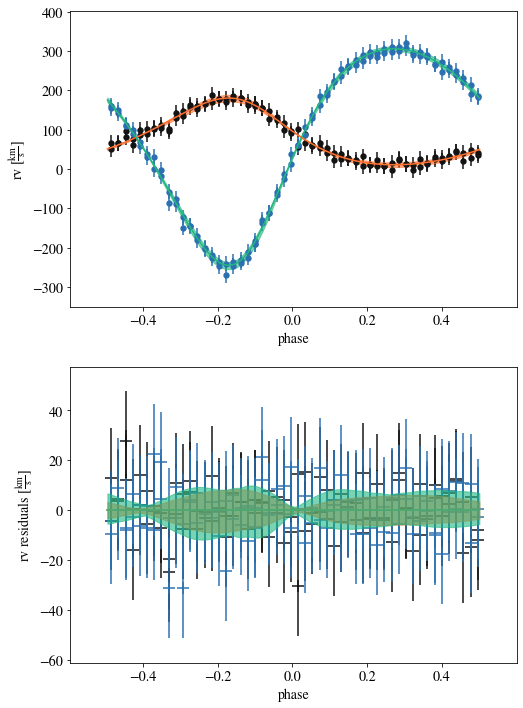

In [17]:
_ = b.plot(kind='rv', model='emcee_posts', x='phases', y='rvs',
          marker={'dataset': '.'})
_ = b.plot(kind='rv', model='emcee_posts', x='phases', y='residuals', 
           z={'dataset': 0, 'model': 1},
           save='figure_posteriors_sample_from_rv.pdf', show=True)